# K-Nearest Neighbors Classifier

1. [The Tasks](#tt) <br>
2. [Loading our Data and Libraries](#ld) <br>
3. [PCA](#pca) <br>
4. [Grid Search](#gr) <br>
5. [Plotting Neighbors](#pl) <br>

***

## The Tasks
<a id="tt" > 

Using the high-level OverFeat features

- Create a Pipeline with PCA and KNeighborsClassifier steps.
- Split the train set into a (smaller) train and validation sets with respectively 3,200 and 800 points.
- Tune k and distance metric using grid search on those train/validation sets.
- Print the validation accuracy of each combination of parameters.
- Find the combination with the best validation accuracy and print it.
- Fit tuned classifier on the entire train set with 4,000 data points. Evaluate and print the test accuracy.
- Pick a test image and plot it with its 10 nearest neighbors from the train set.

***

## Loading/Preparing our Data and Libraries
<a id="ld" > 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
sns.set()
%matplotlib inline

In [2]:
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())
print('Our data countains {}'.format(cifar4.keys()))

Our data countains dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [3]:
X_of = cifar4['overfeat']
X_pix = cifar4['pixels']
y = cifar4['labels']
names = cifar4['names']

print('There are {:,} rows '.format(X_of.shape[0]) + 'and {} columns in our X dataset'.format(X_of.shape[1]))
print('There are {:,} rows in our y dataset '.format(y.shape[0]))

print('X has datatype:', X_of.dtype)
print('y has datatype:', y.dtype)

There are 5,000 rows and 4096 columns in our X dataset
There are 5,000 rows in our y dataset 
X has datatype: float32
y has datatype: int64


In [4]:
# We split our data and make sure that the sets have the same proportion of datapoints in each class by setting stratify=y
X_tr, X_te, y_tr, y_te, pix_tr, pix_te, label_tr, label_te = train_test_split(X_of, y, 
                                                                              X_pix, y,
                                                                              test_size=1000, random_state=0, 
                                                                              stratify=y)

print('There are {:,} rows '.format(X_tr.shape[0]) + 'and {} columns in our X_tr dataset'.format(X_tr.shape[1]))
print('There are {:,} rows '.format(X_te.shape[0]) + 'and {} columns in our X_te dataset'.format(X_te.shape[1]))

There are 4,000 rows and 4096 columns in our X_tr dataset
There are 1,000 rows and 4096 columns in our X_te dataset


***

## PCA
<a id="pca" > 

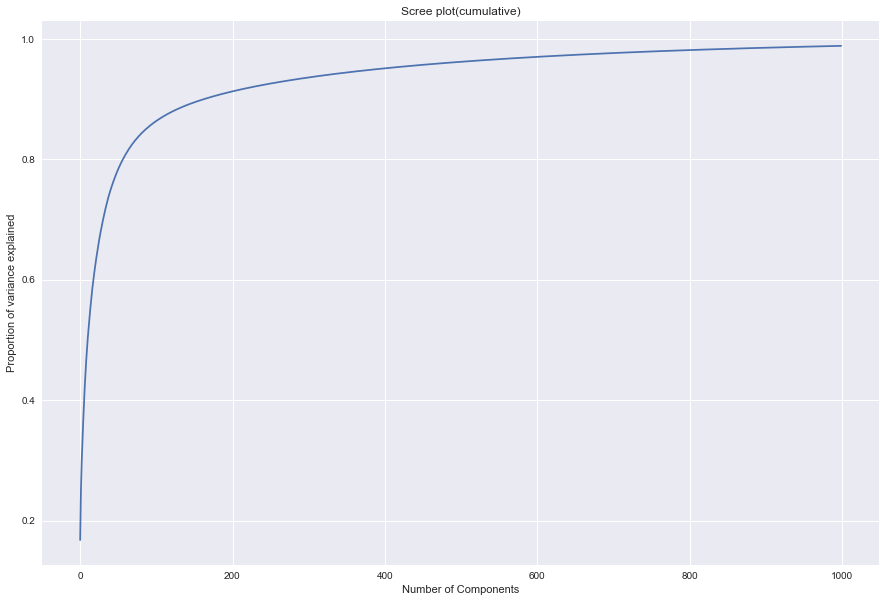

In [5]:
# Creating a scree plot
pca = PCA(n_components=None)
pca.fit(X_of)
pve = pca.explained_variance_ratio_
fig = plt.figure(figsize=(15, 10))
plt.plot(np.cumsum(pve[:1000]))
plt.xlabel('Number of Components')
plt.ylabel('Proportion of variance explained')
plt.title('Scree plot(cumulative)')
plt.show()

200 Components seem to be more than enough to retain 90+% of the explained variance

In [6]:
pca = PCA(n_components=200)

# We set n_jobs to -1 in order to parallelize calculations
knn = KNeighborsClassifier(n_neighbors=10, 
                           n_jobs=-1)

# We create a 2 step pipeline 
pipe = Pipeline([('pca', pca),
                 ('knn', knn)])

pipe.fit(X_tr, y_tr)

accuracy = pipe.score(X_te, y_te)
print ('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.771


In [7]:
# Splitting our test data into a train- and validation set
X_tr_2 ,X_val, y_tr_2, y_val = train_test_split(X_tr, y_tr, test_size=800, random_state=0, stratify=y_tr)

print('There are {:,} rows '.format(X_tr.shape[0]) + 'and {} columns in our X_tr dataset'.format(X_tr.shape[1]))
print('There are {:,} rows '.format(X_val.shape[0]) + 'and {} columns in our X_val dataset'.format(X_val.shape[1]))
print('There are {:,} rows '.format(y_tr.shape[0]) + 'in our y_tr dataset')
print('There are {:,} rows '.format(y_val.shape[0]) + 'in our y_val dataset')

There are 4,000 rows and 4096 columns in our X_tr dataset
There are 800 rows and 4096 columns in our X_val dataset
There are 4,000 rows in our y_tr dataset
There are 800 rows in our y_val dataset


***

## Grid Search
<a id="gr" > 

In [8]:
# L1 and L2 distance
distance_types = [1, 2]
k_values = range(5,150,5) 

grid = ParameterGrid({'knn__n_neighbors':k_values,
                      'knn__p':distance_types})

print ('There are {} possible combinations'.format(len(grid)))

There are 58 possible combinations


In [9]:
test_scores = []

for params_dict in grid:
    pipe.fit(X_tr_2, y_tr_2)
    # We save each score for further review later
    params_dict['accuracy'] = pipe.score(X_val, y_val)
    test_scores.append(params_dict)

In [10]:
test_scores = pd.DataFrame(test_scores)
# Top ten test-scores
test_scores.sort_values(by='accuracy', ascending=False).head(len(grid)).head(10)

,accuracy,knn__n_neighbors,knn__p
23,0.76375,60,2
37,0.76375,95,2
20,0.76375,55,1
50,0.76375,130,1
18,0.76375,50,1
49,0.76375,125,2
44,0.76250,115,1
43,0.76250,110,2
26,0.76250,70,1
21,0.76125,55,2


In [11]:
best = test_scores['accuracy'].idxmax()
print ('Our best accuracy was achieves with a k of {} and a L{} distance metric'
       .format(test_scores.loc[best,'knn__n_neighbors'], test_scores.loc[best,'knn__p']))

Our best accuracy was achieves with a k of 50 and a L1 distance metric


In [12]:
knn_best = KNeighborsClassifier(p=2, 
                                n_neighbors=15, 
                                algorithm='brute', 
                                n_jobs=-1)

pipe = Pipeline([('pca', PCA(n_components=200)),
                 ('knn', knn_best)])

pipe.fit(X_tr, y_tr)
accuracy_best = pipe.score(X_te, y_te)
print ('K-NN accuracy on the test set: {:.3f}'.format(accuracy_best))

K-NN accuracy on the test set: 0.776


***

## Plotting Neighbors
<a id="pl" > 

In [13]:
random_number = random.randint(0, len(X_te))

# We take a random image from the test set
X_img = X_te[random_number].reshape(1, -1)

# We apply PCA and find its 10 neighrest neighbors
X_pca_2d = pca.transform(X_img)
neighbors = knn_best.kneighbors(X_pca_2d, 10)

idx = np.ravel(neighbors[1])

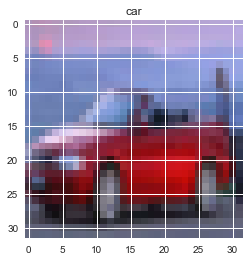

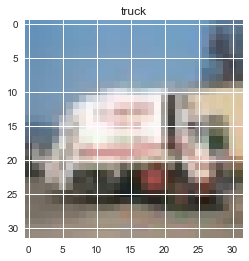

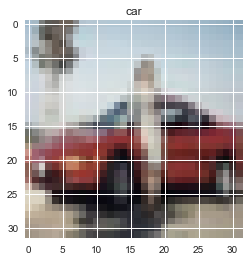

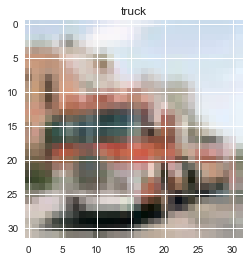

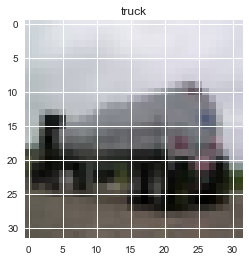

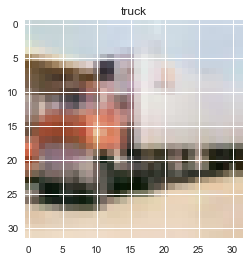

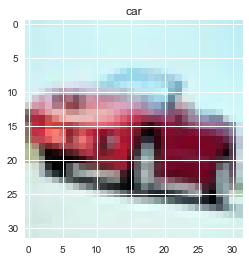

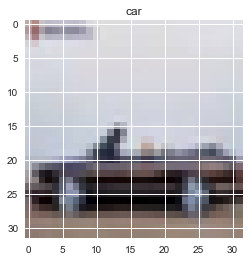

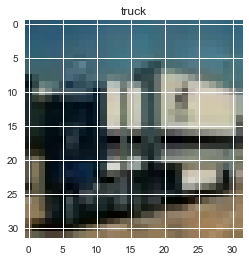

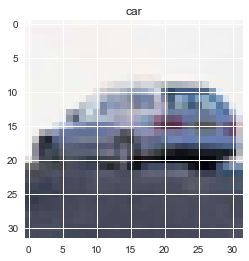

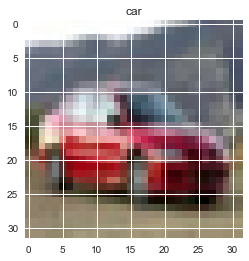

In [14]:
# Plotting the original image
flat_img = pix_te[random_number]
img = flat_img.reshape(32, 32, 3)
plt.imshow(img)
plt.title(names[label_te[random_number]])
plt.show()

# Plotting its 10 neighrest neighbors from the train set
for i, x in enumerate(idx):
    flat_img = pix_tr[x, :]
    img = flat_img.reshape(32, 32, 3)
    plt.imshow(img)
    plt.title(names[label_tr[x]])
    plt.show()